# Data and Scripts Assessing the Accuracy of Bed-occupancy with a tina.care&reg; Bed Sensor
This repository contains data in folder `ftn_study` and scripts in notebook `index.ipynb` that was used in the draft article [1] evaluating the bed sensor device tina.care&reg; (https://tina.care/) developed by Bonitoo s.r.o.(https://bonitoo.io).
[1] T.Kulhánek, K.Hošková, J.Feberová, M.Malecha: **Assessing the Accuracy of Bed-occupancy with a tina.care&reg; Bed Sensor in Hospital Wards and Home Care Settings: Pilot Study**. draft not yet published
# Instructions
Each cell contains code or markdown text. Focus or click on the first  cell and press `Shift+Enter`. This runs current cell, the notebook displays the output bellow and moves to next cell. Repeat `Shift+Enter` to run other cells. You may modify the script in the cell and rerun it.


## 1. read observation from JSON files


In [1]:
## 1.1 get observation data files 
import glob
# Directory to search for .json files
directory = 'ftn_study/'
# Get a list of all .json files in the specified directory
filenames = glob.glob(f'{directory}*.json')
# Print the list of .json files
print(filenames)

['ftn_study/anotina-TINA-FTN-73-2024-09-16T08_4.json', 'ftn_study/anotina-TINA-FTN-42-2024-09-16T08_4.json', 'ftn_study/anotina-TINA-FTN-41-2024-09-16T08_2.json', 'ftn_study/anotina-TINA-FTN-62-2024-09-24T07_40.json', 'ftn_study/anotina-TINA-FTN-42-2024-09-24T07_04.json', 'ftn_study/anotina-TINA-FTN-91-2024-09-30T09_32.json', 'ftn_study/anotina-TINA-FTN-81-2024-09-16T11_4.json', 'ftn_study/anotina-TINA-FTN-52-2024-10-11T08_06.json', 'ftn_study/anotina-TINA-TOMASK-2024-10-03T0939.json', 'ftn_study/anotina-TINA-FTN-82-2024-09-24T07_53.json', 'ftn_study/anotina-TINA-FTN-92-2024-09-24T08_00.json', 'ftn_study/anotina-TINA-FTN-72-2024-09-16T09_3.json', 'ftn_study/anotina-TINA-IVAN-2024-09-23T16_30.json', 'ftn_study/anotina-TINA-FTN-63-2024-09-16T08_1.json', 'ftn_study/anotina-TINA-FTN-13-2024-09-30T07_20.json', 'ftn_study/anotina-TINA-FTN-61-2024-10-11T08_15.json', 'ftn_study/anotina-TINA-FTN-32-2024-09-17T07_4.json', 'ftn_study/anotina-TINA-FTN-62-2024-09-24T06_45.json', 'ftn_study/anotina-

In [2]:
## 1.2 read observation data files and fill ftn_data list
import json
ftn_data = []
# Open the JSON file
for filename in filenames:
    with open(filename, 'r') as file:
        # Load the JSON data into a Python dictionary
        data = json.load(file)        
        ftn_data.extend(data)

In [3]:
# 1.3 Check and find items where 'device' is an empty string, e.g. observation was not tagged, or tagged later. If nothing is printed then OK.
empty_device_items = [item for item in ftn_data if item['device'] == '']

# Print the items with an empty 'device' field
for item in empty_device_items:
    print(item)

In [4]:
# 1.4 get list of unique device names in ftn study log, and show the number
# Use a set comprehension to get unique device names
unique_devices = {log["device"] for log in ftn_data}

# Convert the set to a list if needed
unique_devices_list = list(unique_devices)
print(f'A total of {len(unique_devices_list)} patients or volunteers were observed and monitored during the study.')

A total of 32 patients or volunteers were observed and monitored during the study.


## 2. define routines to compare observations, get sensor data stored in HDF5 file

In [5]:
# 2.1 functions to parse logs to discover unique observation
from datetime import datetime, timedelta

# returns study or studies with comparison of observation and sensor data with true positives, true negatives, false positives and false negatives that was device_id - there is one observation per day
def parselog_stored(device_id='TINA-FTN-41', parsed_log= ftn_data, threshold = 0, time_delta_s=10, compare_strategy=0,inbed2ndperson=False):
        
    # Use a list comprehension to filter logs by device ID
    filtered_logs = [log for log in ftn_data if log['device'] == device_id]
    # Convert log times to datetime objects and calculate 'inbed' state
    # entry value should be > 0, but 100 means that second person is near the bed, but not in bed
    if inbed2ndperson:
        #consider '2nd person near bed' log as inbed even nobody is in bed
        parsed_log = [{"time": datetime.fromisoformat(entry["time"].replace("Z", "+00:00")), "inbed": 1 if (entry["value"]) > 0 else 0} for entry in filtered_logs]
    else:
        # do not count 2nd person near bed to statistics
        parsed_log = [{"time": datetime.fromisoformat(entry["time"].replace("Z", "+00:00")),
                       "inbed": 2 if ((entry["value"] == 100) or (entry["value"] == 90 )) else (1 if (entry["value"] % 100) > 0 else 0)}
                       #"inbed": 2 if ((entry["value"] == 100)) else (1 if (entry["value"] % 100) > 0 else 0)}
              for entry in filtered_logs]
        #consider '2nd person near bed' as not in bed if nobody is in bed
        #parsed_log = [{"time": datetime.fromisoformat(entry["time"].replace("Z", "+00:00")), "inbed": 1 if (entry["value"] % 100) > 0 else 0} for entry in filtered_logs]
    
    # Sort the parsed log by time (just in case it's not sorted)
    parsed_log.sort(key=lambda x: x["time"])
    
    # Convert 'time' strings to datetime objects for accurate processing
    #for entry in parsed_log:
    #    entry["time"] = datetime.fromisoformat(entry["time"].replace("Z", "+00:00"))
    
    # Extract unique days from the log timestamps
    unique_days = sorted(set(entry["time"].date() for entry in parsed_log))
    study = []
    # Process logs day by day
    for day in unique_days:
        # Filter logs to only include entries from the current day
        day_logs = [entry for entry in parsed_log if entry["time"].date() == day]
        
        # Determine the start_time and end_time for this day
        start_time = min(entry["time"] for entry in day_logs)
        end_time = max(entry["time"] for entry in day_logs)
        
        # Generate a list of times at every 10-second interval for this day
        new_times = []
        current_time = start_time
        
        while current_time <= end_time:
            new_times.append(current_time)
            current_time += timedelta(seconds=time_delta_s)
        
        # Process the new 10-second intervals for the current day
        TP,TN,FP,FN,obs = process_new_times_stored(new_times,parsed_log,start_time,end_time,device_id,threshold,compare_strategy)
        if TP is not None:
            study.append({'device':device_id,'TP':TP,'TN':TN,'FP':FP,'FN':FN,'start_time':start_time,'end_time':end_time,'obs':obs})
        else:
            print(f'found None in true positive for {device_id} between times {start_time} and {end_time}. Discarding results')
    print(f'studies in file {len(study)}')
    return study    

# compares observation with sensor data computed true positives, true negatives, false positives and false negatives
def process_new_times_stored(new_times,parsed_log,start_time,end_time,device_id,threshold = 0,compare_strategy=0):
    # process the intervals
    print(f"Processing {len(new_times)} intervals...")
    # Determine the 'inbed' state for each new time
    bed_state = []
    current_state = 0  # Default initial state (empty bed)

    for new_time in new_times:
        # Update the state if there's a new log entry before the current interval time
        while parsed_log and parsed_log[0]["time"] <= new_time:
            current_state = parsed_log.pop(0)["inbed"]

        # Append the new time and current state to the result
        bed_state.append({"time": new_time.isoformat(), "inbed": current_state})
    #return bed_state
    #get inbed state from DB
    device_id_pg = device_id.replace('-','_')
    print(device_id_pg,start_time.isoformat(),end_time.isoformat())
    #sensor_df = getMiniDataStatFrom('signal_strength',get_device_id(device_id_pg),False,False,False,'1M',start_time.isoformat(),end_time.isoformat(),True,False)
    sensor_df = getMiniDataStatFromHDF5(get_device_id(device_id_pg),start_time.isoformat());
    observation_df = pd.DataFrame(bed_state)
    if sensor_df is None:
        return None,None,None,None,None
    size_df = len(sensor_df)
    if compare_strategy == 0:
        for i in range(0,size_df):
            if (sensor_df.iloc[i]['Value'] > threshold):
                observation_df.loc[i,'inbed_sensor'] = 1
            else: 
                observation_df.loc[i,'inbed_sensor'] = 0
    else:
        if compare_strategy ==1:
            for i in range(0,size_df-1):
                if (sensor_df.iloc[i+1]['Value'] > threshold):
                    observation_df.loc[i,'inbed_sensor'] = 1
                else: 
                    observation_df.loc[i,'inbed_sensor'] = 0
        
    # Calculate TP, TN, FP, FN
    TP = ((observation_df['inbed'] == 1) & (observation_df['inbed_sensor'] == 1)).sum()
    TN = ((observation_df['inbed'] == 0) & (observation_df['inbed_sensor'] == 0)).sum()
    FP = ((observation_df['inbed'] == 0) & (observation_df['inbed_sensor'] == 1)).sum()
    FN = ((observation_df['inbed'] == 1) & (observation_df['inbed_sensor'] == 0)).sum()    
    Sensitivity = TP / (TP+FN)
    Specificity = TN / (TN+FP)
    Accuracy = (TP + TN ) / (TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    F1_score = 2*Sensitivity*Precision/(Sensitivity+Precision)
    accuracy_study = [
    ["","in bed","out bed","total"],
    ["sensor in bed",TP,FP,TP+FP],
    ["sensor out bed",FN, TN,TN+FN],
    ["total",TP+FN, TN+FP,""],
    ["-----","","",""],
    ["sensitivity [%]",Sensitivity*100,"",""],
    ["specificity [%]",Specificity*100,"",""],
    ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
    ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
    ["prevalence [%]",(TP+FN)/size_df *100,"",""],
    ["accuracy [%]",Accuracy * 100,"",""],
    ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
    ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
    ["f1 score",F1_score,'','']    
    ]        
    return TP,TN,FP,FN,observation_df


In [6]:
import re
import pandas as pd
def getMiniDataStatFromHDF5(device_id,start_time):
    raw_key = f'{device_id}_{start_time}'
    key = re.sub(r'[:.\-+]', '_', raw_key)
    with pd.HDFStore('ftn_study/sensor_data.h5') as store:
    # Retrieve the DataFrame using the valid key
        try:
            df = store.get(key) 
        except KeyError:
            df = None
    return df

In [7]:
# define device IDs - for mapping between data stored in HDF5 files and device names stored in observation
TINA_FTN_11 ='ASWA.2D-13360111504B57313534033B48'
TINA_FTN_12 ='ASWA.2D-133601115048573533380F7630'
TINA_FTN_13 ='ASWA.2D-133601115048573533380F7551'

TINA_FTN_21 ='ASWA.2D-133601115048573533380F762B'
TINA_FTN_22A='ASWA.2D-13360111504B57313534032548'
TINA_FTN_22B='ASWA.2D-1336011150485735333809200F'
TINA_FTN_23 ='ASWA.2D-13360111504B57313534056551'

TINA_FTN_31 = 'ASWA.2D-133601115048573533380F7550'
TINA_FTN_32 = 'ASWA.2D-133601115048573533380F7654'
TINA_FTN_33 = 'ASWA.2D-13360111504B5731353403211B'

TINA_FTN_41='ASWA.2D-133601115048573533380F5549'
TINA_FTN_42='ASWA.2D-13360111504B57313534034948'
TINA_FTN_43='ASWA.2D-133601115048573533380F755F'
TINA_FTN_51 = 'ASWA.2D-13360111504B5731353403271C'
TINA_FTN_52 = 'ASWA.2D-133601115048573533380F7553'
TINA_FTN_53 = 'ASWA.2D-13360111504B57313534052E09'
TINA_FTN_61 = 'ASWA.2D-13360111504B57313534030C1C'
TINA_FTN_62 = 'ASWA.2D-13360111504B57313534054802'
TINA_FTN_63 = 'ASWA.2D-133601115048573533380F7556'
TINA_FTN_71 = 'ASWA.2D-13360111504857353338013247'
TINA_FTN_72 = 'ASWA.2D-1336011150485735333802531C'
TINA_FTN_73 = 'ASWA.2D-13360111504857353338046565'
TINA_FTN_81 = 'ASWA.2D-13360111504B57313534031848'
TINA_FTN_82 = 'ASWA.2D-13360111504B57313534032D1C'
TINA_FTN_91 = 'ASWA.2D-1336011150485735333801724E'
TINA_FTN_92 = 'ASWA.2D-13360111504857353338014D3A'
TINA_FTN_101 = 'ASWA.2D-13360111504857353338023512'
TINA_FTN_102 = 'ASWA.2D-13360111504857353338016343'

TINA_LDN_1301 = 'ASWA.2D-13360111504857353334021D5B'
TINA_LDN_1302 = 'ASWA.2D-1336011150485735333402784F'
TINA_LDN_1303 = 'ASWA.2D-13360111504857353334082219'
TINA_LDN_1304 = 'ASWA.2D-13360111504857353334023258'

TINA_LDN_1503 = 'ASWA.2D-133601115048573533380F7848'
TINA_LDN_1503B= 'ASWA.2D-133601115048573533380E6869'
TINA_LDN_1502 = 'ASWA.2D-1336011150485735333402325B'
TINA_LDN_1501 = 'ASWA.2D-13360111504857353334082218'
TINA_LDN_1504 = 'ASWA.2D-13360111504857353338016C69'

TINA_JOZEF  = 'ASWA.2D-1336011150485735333407512F'
TINA_TOMASK = 'ASWA.2D-13360111504B5731353403374A'
TINA_HSENIOR = 'ASWA.2D-13360111504857353338015647'

TINA_PAS_71 = 'ASWA.2D-13360111504B57313534052750'
TINA_PAS_72 = 'ASWA.2D-133601115048573533380F7628'
TINA_PAS_73 = 'ASWA.2D-13360111504B5731353403281C'
TINA_PAS_51 = 'ASWA.2D-13360111504B57313534033948'

TINA_STA_MO = 'ASWA.2D-133601115048573533380E4301'
TINA_STA_OR = 'ASWA.2D-133601115048573533380A461A'
TINA_STA_ZE = 'ASWA.2D-13360111504857353338023958'
TINA_STA_ZL = 'ASWA.2D-13360111504857353338020840'

TINA_JOZEF1  = 'ASWA.2D-1336011150485735333801142E'
TINA_HSENIOR = 'ASWA.2D-13360111504857353338015647'
TINA_100     = 'ASWA.2D-13360111504857353334025442'
TINA_IVAN    = 'ASWA.2D-13360111504857353338015214'
TINA_MIREK   = 'ASWA.2D-13360111504857353338014003'
TINA_MIREKDEV= 'ASWA.2D-133601115048573533380F755A'
TINA_ALESDEV = 'ASWA.2D-13360111504B57313534031748'

TINA_LF1_JF   = 'ASWA.2D-13360111504857353334082215'

TINA_INFINEON = 'ASWA.2D-13CDCDA0000040C11D13953107'

#andromeda devices
AN11_2206 = 'AN11.2206-f412fa4489bc'
AN11_2211 = 'AN11.2211-f412fae23fe0'
AN11_2303 = 'AN11.2303-f412fae23eb8'
AN11_2306 = 'AN11.2306-f412fae23f84'
AN11_brd  = 'AN11.brd-34ab955c41b8'
AN11_2304 = 'AN11.2304-f412fae254a4'


# first categorize all devices to some list 
# Initialize lists to hold device IDs for each category
FTN_devices = {}
LDN_devices = {}
PAS_devices = {}
STA_devices = {}
TEST_devices = {}
AN11_devices = {}
ALL_devices = {}

globals_snapshot = list(globals().items())

# Iterate over all global variables
for var_name, var_value in globals_snapshot:
    # Ensure we're dealing with the string variables defined for device IDs
    if isinstance(var_value, str) and ((var_value.startswith('ASWA') and var_name.startswith('TINA')) or (var_value.startswith('AN11') and var_name.startswith('AN11'))):
        ALL_devices[var_name] = var_value
        # Categorize based on the presence of specific substrings in the variable name
        if 'FTN' in var_name:
            FTN_devices[var_name] = var_value
        elif 'LDN' in var_name:
            LDN_devices[var_name] = var_value
        elif 'PAS' in var_name:
            PAS_devices[var_name] = var_value
        elif 'STA' in var_name:
            STA_devices[var_name] = var_value
        elif 'AN11' in var_name:
            AN11_devices[var_name] = var_value            
        else:
            # If the variable name does not contain any of the substrings, categorize as TEST
            TEST_devices[var_name] = var_value
def get_device_name(device_id):
    # Find the key associated with the known value
    found_key = ''
    for key, value in ALL_devices.items():
        if value == device_id:            
            found_key = key
            break  # Break after finding the first match
    return found_key

def get_device_id(device_name):
    # Find the key associated with the known value
    found_id = ''
    for key, value in ALL_devices.items():
        if key == device_name:            
            found_id = value
            break  # Break after finding the first match
    return found_id

## 3. compare observations with data from sensors

In [8]:
observations = []
for device in unique_devices_list:
    obs = parselog_stored(device)
    observations.extend(obs)

Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.738000+00:00
studies in file 1
Processing 70 intervals...
TINA_FTN_33 2024-09-16T12:01:11.183000+00:00 2024-09-16T12:12:46.361000+00:00
Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00


/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/6

Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value e

studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Process

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)


In [9]:
print(f'Total {len(observations)} valid observations were performed')

Total 53 valid observations were performed


## 4. Accuracy study - compute sensitivity,specificity and other metrics

In [10]:
def accuracy_study(raw_observations,exclude_device):
    # Create a new array excluding logs where 'device' is equal to 'my_device'
    observations = [log for log in raw_observations if log['device'] != exclude_device]

    TP = sum(log['TP'] for log in observations)
    TN = sum(log['TN'] for log in observations)
    FP = sum(log['FP'] for log in observations)
    FN = sum(log['FN'] for log in observations)
    size_study = sum(len(log['obs']) for log in observations)
    Sensitivity = TP / (TP+FN)
    Specificity = TN / (TN+FP)
    Accuracy = (TP + TN ) / (TP+TN+FP+FN)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    prevalence = (TP+FN)/size_study
    PLR = Sensitivity/(1-Specificity)
    NLR = (1-Sensitivity)/Specificity
    F1_score = 2*Sensitivity*PPV/(Sensitivity+PPV)
    accuracy_study = [
    ["","in bed","out bed","total"],
    ["sensor in bed",TP,FP,TP+FP],
    ["sensor out bed",FN, TN,TN+FN],
    ["total",TP+FN, TN+FP,""],
    ["-----","","",""],
    ["sensitivity [%]",Sensitivity*100,"",""],
    ["specificity [%]",Specificity*100,"",""],
    ["pos. pred.v. [%]", PPV *100,"",""],
    ["neg. pred.v. [%]",NPV *100,"",""],
    ["prevalence [%]", prevalence *100,"",""],
    ["accuracy [%]",Accuracy * 100,"",""],
    ["pos. likelihood ratio LR+",PLR,"",""],
    ["neg. likelihood ratio LR-",NLR,"",""],
    ["f1 score [%]",F1_score*100,"",""],
    ["observations in study",len(observations),"",""]    
]
    for row in accuracy_study[0:]:  # Skip the header in data for printing
        # Format row[1] to 2 decimal places if it's a number
        if isinstance(row[1], (int, float)):
            row_1_formatted = f"{row[1]:.2f}"  # Format to 2 decimal places            
        else:
            row_1_formatted = row[1]  # Keep as is if not a number    
        print(f"{row[0]:<25} {row_1_formatted:<10} {row[2]:<10} {row[3]:<10}")
    return Sensitivity,Specificity,Accuracy,PPV


In [11]:
sen,spe,acc,ppv = accuracy_study(observations,"")

                          in bed     out bed    total     
sensor in bed             3642       386        4028      
sensor out bed            37         3220       3257      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.99                           
specificity [%]           89.30                           
pos. pred.v. [%]          90.42                           
neg. pred.v. [%]          98.86                           
prevalence [%]            38.58                           
accuracy [%]              94.19                           
pos. likelihood ratio LR+ 9.25                            
neg. likelihood ratio LR- 0.01                            
f1 score [%]              94.51                           
observations in study     53.00                           


## 5. ROC curve for different threshold value

In [12]:
roc = []

import matplotlib.pyplot as plt

# Initialize lists to store TPR (sensitivity) and FPR (1 - specificity)
tpr_list = []
fpr_list = []
thr_list = []
obs_list = []
acc_list = []
prec_list = []

# Loop over threshold values from 28.5 to 35 with a step of 0.5
thresholds = [i for i in range(285, 451, 5)]  # Multiply by 10 to avoid floating point range issues
thresholds = [t / 10 for t in thresholds]  # Convert back to floating point

for threshold in thresholds:
    # Calculate sensitivity and specificity for the given threshold
    observations2 = []
    for device in unique_devices_list:
        obs = parselog_stored(device,ftn_data,threshold)
        observations2.extend(obs)

    sensitivity, specificity,accuracy,precision = accuracy_study(observations2,"")
    
    # True Positive Rate (TPR) = sensitivity
    tpr = sensitivity
    
    # False Positive Rate (FPR) = 1 - specificity
    fpr = 1 - specificity
    
    # Append TPR and FPR values to the lists
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    thr_list.append(threshold)
    acc_list.append(accuracy)
    prec_list.append(precision)
    obs_list.append(observations2.copy())
fpr_list.insert(0,1)
tpr_list.insert(0,1)
fpr_list.append(0)
tpr_list.append(0)

Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.738000+00:00
studies in file 1
Processing 70 intervals...
TINA_FTN_33 2024-09-16T12:01:11.183000+00:00 2024-09-16T12:12:46.361000+00:00
Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00


/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/6

Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:0

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value e

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 2
Processing 25 intervals...
TINA_FTN_81 2024-09-16T11:14:50.925000+00:00 2024-09-16T11:18:55.650000+00:00
Processing 69 intervals...
TINA_FTN_81 2024-09-20T09:23:29.370000+00:00 2024-09-20T09:34:57.597000+00:00
Processing 139 intervals...
TINA_FTN_81 2024-09-24T06:32:31.973000+00:00 2024-09-24T06:55:32.192000+00:00
studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00


/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3642       386        4028      
sensor out bed            37         3220       3257      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.99                           
specificity [%]           89.30                           
pos. pred.v. [%]          90.42                           
neg. pred.v. [%]          98.86                           
prevalence [%]            38.58                           
accuracy [%]              94.19                           
pos. likelihood ratio LR+ 9.25                            
neg. likelihood ratio LR- 0.01                            
f1 score [%]              94.51                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3642       377        4019      
sensor out bed            37         3229       3266      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.99                           
specificity [%]           89.55                           
pos. pred.v. [%]          90.62                           
neg. pred.v. [%]          98.87                           
prevalence [%]            38.58                           
accuracy [%]              94.32                           
pos. likelihood ratio LR+ 9.47                            
neg. likelihood ratio LR- 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Process

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
T

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 70 intervals...
TINA_FTN_33 2024-09-16T12:01:11.183000+00:00 2024-09-16T12:12:46.361000+00:00
Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3640       357        3997      
sensor out bed            39         3249       3288      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.94                           
specificity [%]           90.10                           
pos. pred.v. [%]          91.07                           
neg. pred.v. [%]          98.81                           
prevalence [%]            38.58                           
accuracy [%]              94.56                           
pos. likelihood ratio LR+ 9.99                            
neg. likelihood ratio LR- 0.01                            
f1 score [%]              94.84                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3637       342        3979      
sensor out bed            42         3264       3306      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
stud

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3634       334        3968      
sensor out bed            45         3272       3317      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.78                           
specificity [%]           90.74                           
pos. pred.v. [%]          91.58                           
neg. pred.v. [%]          98.64                           
prevalence [%]            38.58                           
accuracy [%]              94.80                           
pos. likelihood ratio LR+ 10.66                           
neg. likelihood ratio LR- 0.01                            
f1 score [%]              95.04                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3630       326        3956      
sensor out bed            49         3280       3329      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Process

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TIN

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
                          in bed     out bed    total     
sensor in bed             3625       317        3942      
sensor out bed            54         3289       3343      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.53                           
specificity [%]           91.21                           
pos. pred.v. [%]          91.96                           
neg. pred.v. [%]          98.38                           
prevalence [%]            38.58                           
accuracy [%]              94.91                           
pos. likelihood ratio LR+ 11.21                           
neg. likelihood ratio LR- 0.02                            
f1 score [%]              95.13                           
observations in study     53.00                           
Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.73800

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3619       303        3922      
sensor out bed            60         3303       3363      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.37                           
specificity [%]           91.60                           
pos. pred.v. [%]          92.27                           
neg. pred.v. [%]          98.22                           
prevalence [%]            38.58                           
accuracy [%]              95.02                           
pos. likelihood ratio LR+ 11.71                           
neg. likelihood ratio LR- 0.02                            
f1 score [%]              95.22                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3614       296        3910      
sensor out bed            65         3310       3375      
total                     3679       3606                 
-----                                                     
sensitivity [%]           98.23                           
specificity [%]           9

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Proce

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],


studies in file 1
                          in bed     out bed    total     
sensor in bed             3603       281        3884      
sensor out bed            76         3325       3401      
total                     3679       3606                 
-----                                                     
sensitivity [%]           97.93                           
specificity [%]           92.21                           
pos. pred.v. [%]          92.77                           
neg. pred.v. [%]          97.77                           
prevalence [%]            38.58                           
accuracy [%]              95.10                           
pos. likelihood ratio LR+ 12.57                           
neg. likelihood ratio LR- 0.02                            
f1 score [%]              95.28                           
observations in study     53.00                           
Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.73800

/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/6930799

Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3583       276        3859      
sensor out bed            96         3330       3426      
total                     3679       3606                 
-----                                                     
sensitivity [%]           97.39                           
specificity [%]           92.35                           
pos. pred.v. [%]          92.85                           
neg. pred.v. [%]          97.20                           
prevalence [%]            38.58                           
accuracy [%]              94.89                           
pos. likelihood ratio LR+ 12.72                           
neg. likelihood ratio LR- 0.03                            
f1 score [%]              95.07                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value e

Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+0

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3561       270        3831      
sensor out bed            118        3336       3454      
total                     3679       3606                 
-----                                                     
sensitivity [%]           96.79                           
specificity [%]           92.51                           
pos. pred.v. [%]          92.95                           
neg. pred.v. [%]          96.58                           
prevalence [%]            38.58                           
accuracy [%]              94.67                           
pos. likelihood ratio LR+ 12.93                           
neg. likelihood ratio LR- 0.03                            
f1 score [%]              94.83                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value e

studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3534       263        3797      
sensor out bed            145        3343       3488      
total                     3679       3606                 
-----                                                     
sensitivity [%]           96.06                           
specificity [%]           92.71                           
pos. pred.v. [%]          93.07                           
neg. pred.v. [%]          95.84                           
prevalence [%]            38.58                           
accuracy [%]              94.40                           
pos. likelihood ratio LR+ 13.17                           
neg. likelihood ratio LR- 0.04                            
f1 score [%]              94.54                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-3

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Processing 25 intervals...
TINA_FTN_81 2024-09-16T11:14:50.925000+00:00 2024-09-16T11:18:55.650000+00:00
Processing 69 intervals..

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
T

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 70 intervals...
TINA_FTN_33 2024-09-16T12:01:11.183000+00:00 2024-09-16T12:12:46.361000+00:00
Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+0

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3471       249        3720      
sensor out bed            208        3357       3565      
total                     3679       3606                 
-----                                                     
sensitivity [%]           94.35                           
specificity [%]           93.09                           
pos. pred.v. [%]          93.31                           
neg. pred.v. [%]          94.17                           
prevalence [%]            38.58                           
accuracy [%]              93.73                           
pos. likelihood ratio LR+ 13.66                           
neg. likelihood ratio LR- 0.06                            
f1 score [%]              93.82                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3435       245        3680      
sensor out bed            244        3361       3605      
total                     3679       3606                 
-----                                                     
sensitivity [%]           93.37                           
specificity [%]           9

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Proce

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
                          in bed     out bed    total     
sensor in bed             3396       238        3634      
sensor out bed            283        3368       3651      
total                     3679       3606                 
-----                                                     
sensitivity [%]           92.31                           
specificity [%]           93.40                           
pos. pred.v. [%]          93.45                           
neg. pred.v. [%]          92.25                           
prevalence [%]            38.58                           
accuracy [%]              92.85                           
pos. likelihood ratio LR+ 13.99                           
neg. likelihood ratio LR- 0.08                            
f1 score [%]              92.88                           
observations in study     53.00                           
Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.73800

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3356       229        3585      
sensor out bed            323        3377       3700      
total                     3679       3606                 
-----                                                     
sensitivity [%]           91.22                           
specificity [%]           93.65                           
pos. pred.v. [%]          93.61                           
neg. pred.v. [%]          91.27                           
prevalence [%]            38.58                           
accuracy [%]              92.42                           
pos. likelihood ratio LR+ 14.36                           
neg. likelihood ratio LR- 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:1

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 139 intervals...
TINA_FTN_81 2024-09-24T06:32:31.973000+00:00 2024-09-24T06:55:32.192000+00:00
studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3314       220        3534      
sensor out bed            365        3386       3751      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/

Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-3

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Process

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
                          in bed     out bed    total     
sensor in bed             3266       215        3481      
sensor out bed            413        3391       3804      
total                     3679       3606                 
-----                                                     
sensitivity [%]           88.77                           
specificity [%]           94.04                           
pos. pred.v. [%]          93.82                           
neg. pred.v. [%]          89.14                           
prevalence [%]            38.58                           
accuracy [%]              91.38                           
pos. likelihood ratio LR+ 14.89                           
neg. likelihood ratio LR- 0.12                            
f1 score [%]              91.23                           
observations in study     53.00                           
Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.73800

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3210       203        3413      
sensor out bed            469        3403       3872      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-0

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             3143       193        3336      
sensor out bed            536        3413       3949      
total                     3679       3606                 
-----                                                     
sensitivity [%]           85.43                           
specificity [%]           94.65                           
pos. pred.v. [%]          94.21                           
neg. pred.v. [%]          86.43                           
prevalence [%]            38.58                           
accuracy [%]              89.99                           
pos. likelihood ratio LR+ 15.96                           
neg. likelihood ratio LR- 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-3

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Processing 25 intervals...
TINA_FTN_81 2024-09-16T11:14:50.925000+00:00 2024-09-16T11:18:55.650000+00:00
Processing 69 intervals...
TINA_FTN_81 2024-09-20T09:23:29.370000+00:00 2024-09-20T09:34:57.597000+00:00
Processing 139 intervals..

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
T

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
                          in bed     out bed    total     
sensor in bed             3072       181        3253      
sensor out bed            607        3425       4032      
total                     3679       3606                 
-----                                                     
sensitivity [%]           83.50                           
specificity [%]           94.98                           
pos. pred.v. [%]          94.44                           
neg. pred.v. [%]          84.95                           
prevalence [%]            38.58                           
accuracy [%]              89.18                           
pos. likelihood ratio LR+ 16.64                           
neg. likelihood ratio LR- 0.17                            
f1 score [%]              88.63                           
observations in study     53.00                           
Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.73800

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             2992       168        3160      
sensor out bed            687        3438       4125      
total                     3679       3606                 
-----                                                     
sensitivity [%]           81.33                           
specificity [%]           95.34                           
pos. pred.v. [%]          94.68                           
neg. pred.v. [%]          83.35                           
prevalence [%]            38.58                           
accuracy [%]              88.26                           
pos. likelihood ratio LR+ 17.46                           
neg. likelihood ratio LR- 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:1

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in s

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             2884       151        3035      
sensor out bed            795        3455       4250      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 70 intervals...
TINA_FTN_33 2024-09-16T12:01:11.183000+00:00 2024-09-16T12:12:46.361000+00:00
Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Processing 25 intervals...
TINA_FTN_81 2024-09-16T11:14:50.925000+00:00 2024-09-16T11:18:55.650000+00:00
Processing 69 intervals...
TINA_FTN_81 2024-09-20T09:23:29.370000+00:00 2024-09-20T09:34:57.597000+00:00
Processing 139 intervals..

/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeW

studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
T

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide


studies in file 1
                          in bed     out bed    total     
sensor in bed             2771       142        2913      
sensor out bed            908        3464       4372      
total                     3679       3606                 
-----                                                     
sensitivity [%]           75.32                           
specificity [%]           96.06                           
pos. pred.v. [%]          95.13                           
neg. pred.v. [%]          79.23                           
prevalence [%]            38.58                           
accuracy [%]              85.59                           
pos. likelihood ratio LR+ 19.13                           
neg. likelihood ratio LR- 0.26                            
f1 score [%]              84.07                           
observations in study     53.00                           
Processing 324 intervals...
TINA_MIREK 2024-10-07T16:51:27.975000+00:00 2024-10-07T17:45:21.73800

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWa

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWa

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             2673       135        2808      
sensor out bed            1006       3471       4477      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 70 intervals...
TINA_FTN_33 2024-09-16T12:01:11.183000+00:00 2024-09-16T12:12:46.361000+00:00
Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWa

Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.67400

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value e

Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Processing 25 intervals...
TINA_FTN_81 2024-09-16T11:14:50.925000+00:00 2024-09-16T11:18:55.650000+00:00
Processing 69 intervals..

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWa

Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in 

/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_3

Processing 158 intervals...
TINA_FTN_33 2024-09-17T07:19:18.716000+00:00 2024-09-17T07:45:38.493000+00:00
studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:2

/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp

studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.82200

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],


studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             2446       124        2570      
sensor out bed            1233       3482       4715      
total                     3679       3606                 
-----                                                     
sensitivity [%]           66.49                           
specificity [%]           96.56                           
pos. pred.v. [%]          95.18                           
neg. pred.v. [%]          73.85                           
prevalence [%]            38.58                           
accuracy [%]              81.37                           
pos. likelihood ratio LR+ 19.33                           
neg. likelihood ratio LR- 0.35                            
f1 score [%]              78.28                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  ["neg. likelihood ratio LR-",(1-Sensitivity)/Specificity,"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:0

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 3
Processing 1029 intervals...
TINA_FTN_102 2024-09-16T10:25:56.212000+00:00 2024-09-16T13:17:19.860000+00:00
studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: Runtime

studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TINA_FTN_21 2024-09-17T07:01:30.751000+00:00 2024-09-17T08:08:20.048000+00:00
studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             2357       120        2477      
sensor out bed            1322       3486       4808      
total                     3679       3606                 
-----                

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


studies in file 2
Processing 329 intervals...
TINA_TOMASK 2024-09-18T18:14:29.950000+00:00 2024-09-18T19:09:17.604000+00:00
Processing 181 intervals...
TINA_TOMASK 2024-09-27T19:45:16.102000+00:00 2024-09-27T20:15:22.770000+00:00
Processing 405 intervals...
TINA_TOMASK 2024-10-02T13:30:28.474000+00:00 2024-10-02T14:37:56.968000+00:00
Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_23 2024-09-16T12:17:15.457000+00:00 2024-09-16T12:33:17.788000+00:00
Processing 44 intervals...
TINA_FTN_23 2024-09-17T07:01:40.114000+00:00 2024-09-17T07:09:00+00:00
studies in file 2
Processing 64 intervals...
TINA_FTN_53 2024-09-30T09:33:26.007000+00:00 2024-09-30T09:44:05.898000+00:00
studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.642000+00:00 2024-09-24T06:56:08.945000+00:00
Processing 175 intervals...
TINA_FTN_42 2024-10-11T08:16:41.503000+00:00 2024-10-11T08:45:45.418000+00:00
studies in file 3
Processing 201 intervals...
TINA_FTN_63 2024-09-16T07:38:43.050000+00:00 2024-09-16T08:12:03.925000+00:00
studies in file 1
Processing 193 intervals...
TINA_FTN_91 2024-09-30T09:00:07.924000+00:00 2024-09-30T09:32:15.338000+00:00
studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+0

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: Runtime

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


studies in file 1
Processing 179 intervals...
TINA_JOZEF1 2024-09-23T18:30:06.826000+00:00 2024-09-23T18:59:50.286000+00:00
studies in file 1
                          in bed     out bed    total     
sensor in bed             2263       109        2372      
sensor out bed            1416       3497       4913      
total                     3679       3606                 
-----                                                     
sensitivity [%]           61.51                           
specificity [%]           96.98                           
pos. pred.v. [%]          95.40                           
neg. pred.v. [%]          71.18                           
prevalence [%]            38.58                           
accuracy [%]              79.07                           
pos. likelihood ratio LR+ 20.35                           
neg. likelihood ratio LR- 0.40                            
f1 score [%]              74.80                           
observations in study     53.00 

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:43:41.801000+00:00 2024-09-16T10:20:42.922000+00:00
Processing 34 intervals...
TINA_FTN_12 2024-09-24T08:15:51.753000+00:00 2024-09-24T08:21:31.001000+00:00
studies in file 2
Processing 361 intervals...
TINA_FTN_52 2024-10-11T07:00:46.352000+00:00 2024-10-11T08:00:50.877000+00:00
studies in file 1
Processing 97 intervals...
TINA_FTN_

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 33 intervals...
TINA_FTN_51 2024-09-16T13:24:26.938000+00:00 2024-09-16T13:29:53.234000+00:00
Processing 36 intervals...
TINA_FTN_51 2024-09-24T08:08:33.468000+00:00 2024-09-24T08:14:23.691000+00:00
Processing 143 intervals...
TINA_FTN_51 2024-09-30T09:45:05.645000+00:00 2024-09-30T10:08:48.088000+00:00
studies in file 3
Processing 138 intervals...
TINA_FTN_82 2024-09-16T11:17:07.223000+00:00 2024-09-16T11:40:00+00:00
Processing 67 intervals...
TINA_FTN_82 2024-09-24T07:40:52.906000+00:00 2024-09-24T07:51:57.204000+00:00
studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 202

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)


Processing 255 intervals...
TINA_TOMASK 2024-10-03T08:56:37.191000+00:00 2024-10-03T09:39:02.963000+00:00
studies in file 4
Processing 214 intervals...
TINA_FTN_11 2024-09-16T09:43:11.492000+00:00 2024-09-16T10:18:41.824000+00:00
Processing 95 intervals...
TINA_FTN_11 2024-09-30T07:21:19.812000+00:00 2024-09-30T07:37:04.977000+00:00
studies in file 2
Processing 128 intervals...
TINA_FTN_101 2024-09-16T10:28:44.405000+00:00 2024-09-16T10:50:00+00:00
studies in file 1
Processing 84 intervals...
TINA_FTN_32 2024-09-17T07:09:46.992000+00:00 2024-09-17T07:23:43.526000+00:00
Processing 67 intervals...
TINA_FTN_32 2024-09-30T08:45:08.862000+00:00 2024-09-30T08:56:16.720000+00:00
studies in file 2
Processing 193 intervals...
TINA_FTN_73 2024-09-16T08:14:44.353000+00:00 2024-09-16T08:46:48.732000+00:00
studies in file 1
Processing 10 intervals...
TINA_FTN_61 2024-10-11T07:15:21.301000+00:00 2024-10-11T07:16:57.689000+00:00
studies in file 1
Processing 223 intervals...
TINA_FTN_12 2024-09-16T09:

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/69307

studies in file 1
Processing 1 intervals...
TINA_LF1_JF 2024-09-20T11:08:48.232000+00:00 2024-09-20T11:08:53.302000+00:00
found None in true positive for TINA-LF1-JF between times 2024-09-20 11:08:48.232000+00:00 and 2024-09-20 11:08:53.302000+00:00. Discarding results
Processing 159 intervals...
TINA_LF1_JF 2024-09-29T18:55:43.287000+00:00 2024-09-29T19:22:03.861000+00:00
Processing 521 intervals...
TINA_LF1_JF 2024-10-08T18:54:30.924000+00:00 2024-10-08T20:21:20.123000+00:00
Processing 385 intervals...
TINA_LF1_JF 2024-10-09T11:16:57.746000+00:00 2024-10-09T12:21:07.208000+00:00
studies in file 3
Processing 196 intervals...
TINA_FTN_31 2024-09-16T11:56:30.139000+00:00 2024-09-16T12:29:07.977000+00:00
Processing 87 intervals...
TINA_FTN_31 2024-09-30T07:51:29.540000+00:00 2024-09-30T08:05:58.548000+00:00
studies in file 2
Processing 140 intervals...
TINA_FTN_42 2024-09-16T08:21:33.810000+00:00 2024-09-16T08:44:48.137000+00:00
Processing 61 intervals...
TINA_FTN_42 2024-09-24T06:45:59.

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:104: RuntimeWarning: invalid value encountered in scalar divide
  Specificity = TN / (TN+FP)
/tmp/ipykernel_32688/693079944.py:105: RuntimeWarning: invalid value encountered in scalar divide
  Accuracy = (TP + TN ) / (TP+TN+FP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ["neg. pred.v. [%]",TN/(TN+FN) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value e

studies in file 1
Processing 99 intervals...
TINA_FTN_43 2024-09-16T08:26:21.674000+00:00 2024-09-16T08:42:49.127000+00:00
Processing 159 intervals...
TINA_FTN_43 2024-09-30T08:12:15.822000+00:00 2024-09-30T08:38:36.511000+00:00
studies in file 2
Processing 1 intervals...
TINA_JOZEF 2024-09-24T07:21:34.187000+00:00 2024-09-24T07:21:34.187000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-24 07:21:34.187000+00:00 and 2024-09-24 07:21:34.187000+00:00. Discarding results
Processing 50 intervals...
TINA_JOZEF 2024-09-26T13:14:17.242000+00:00 2024-09-26T13:22:33.407000+00:00
found None in true positive for TINA-JOZEF between times 2024-09-26 13:14:17.242000+00:00 and 2024-09-26 13:22:33.407000+00:00. Discarding results
studies in file 0
Processing 43 intervals...
TINA_FTN_71 2024-09-16T12:44:25.730000+00:00 2024-09-16T12:51:31.518000+00:00
Processing 7 intervals...
TINA_FTN_71 2024-09-24T07:26:04.040000+00:00 2024-09-24T07:27:08.907000+00:00
studies in file 2
Process

/tmp/ipykernel_32688/693079944.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  ["pos. likelihood ratio LR+",Sensitivity/(1-Specificity),"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)
/tmp/ipykernel_32688/693079944.py:106: RuntimeWarning: invalid value encountered in scalar divide
  Precision = TP/(TP+FP)
/tmp/ipykernel_32688/693079944.py:116: RuntimeWarning: invalid value encountered in scalar divide
  ["pos. pred.v. [%]",TP/(TP+FP) *100,"",""],
/tmp/ipykernel_32688/693079944.py:103: Runtime

studies in file 2
Processing 114 intervals...
TINA_IVAN 2024-09-23T16:10:35.858000+00:00 2024-09-23T16:29:32.283000+00:00
studies in file 1
Processing 211 intervals...
TINA_FTN_72 2024-09-16T08:51:46.541000+00:00 2024-09-16T09:26:54.248000+00:00
Processing 2 intervals...
TINA_FTN_72 2024-09-30T08:40:55.541000+00:00 2024-09-30T08:41:09.592000+00:00
studies in file 2
Processing 330 intervals...
TINA_FTN_41 2024-09-16T07:46:40.827000+00:00 2024-09-16T08:41:37.342000+00:00
studies in file 1
Processing 280 intervals...
TINA_FTN_13 2024-09-30T06:32:51.495000+00:00 2024-09-30T07:19:21.522000+00:00
studies in file 1
Processing 156 intervals...
TINA_FTN_92 2024-09-24T07:31:03.749000+00:00 2024-09-24T07:56:59.178000+00:00
studies in file 1
Processing 69 intervals...
TINA_FTN_62 2024-09-16T13:05:29.829000+00:00 2024-09-16T13:16:53.078000+00:00
Processing 339 intervals...
TINA_FTN_62 2024-09-24T06:43:45.167000+00:00 2024-09-24T07:40:07.689000+00:00
studies in file 2
Processing 401 intervals...
TIN

/tmp/ipykernel_32688/693079944.py:103: RuntimeWarning: invalid value encountered in scalar divide
  Sensitivity = TP / (TP+FN)


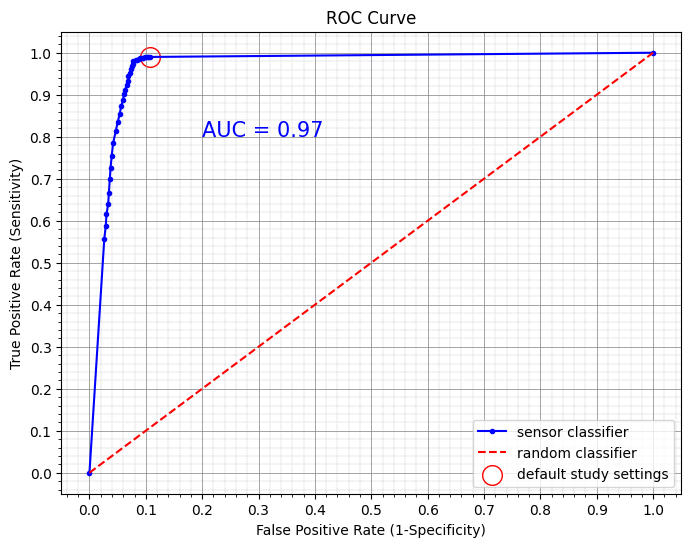

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import auc

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, marker='.', linestyle='-', color='b', label='sensor classifier')

# Set the labels and title
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

# Optionally, plot a diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='random classifier')

# Enable minor ticks and grid
plt.minorticks_on()

# Set major grid with step 0.1 using MultipleLocator
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Set major grid
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')

# Set minor grid with step 0.05
plt.grid(True, which='minor', linestyle=':', linewidth='0.3', color='gray')

# Plot a special point as a red circle at (fpr_list[1], tpr_list[1])
plt.scatter(fpr_list[1], tpr_list[1], color='white',s=200, edgecolor='red', label="default study settings")
plt.legend()

# Compute the Area Under the ROC Curve (AUC) from fpr and tpr
roc_auc = auc(fpr_list, tpr_list)
# Add AUC label to the chart (position it in the top-left corner)
plt.text(0.2, 0.8, f'AUC = {roc_auc:.2f}', fontsize=15, color='blue', ha='left')

# Save the plot to a PNG file
plt.savefig("roc_study_patients_stored.png", format="png", dpi=300)
# Show the plot
plt.show()


## 6. Testing cohort statistics

/tmp/ipykernel_32688/1193932867.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend()
/tmp/ipykernel_32688/1193932867.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[4].legend()


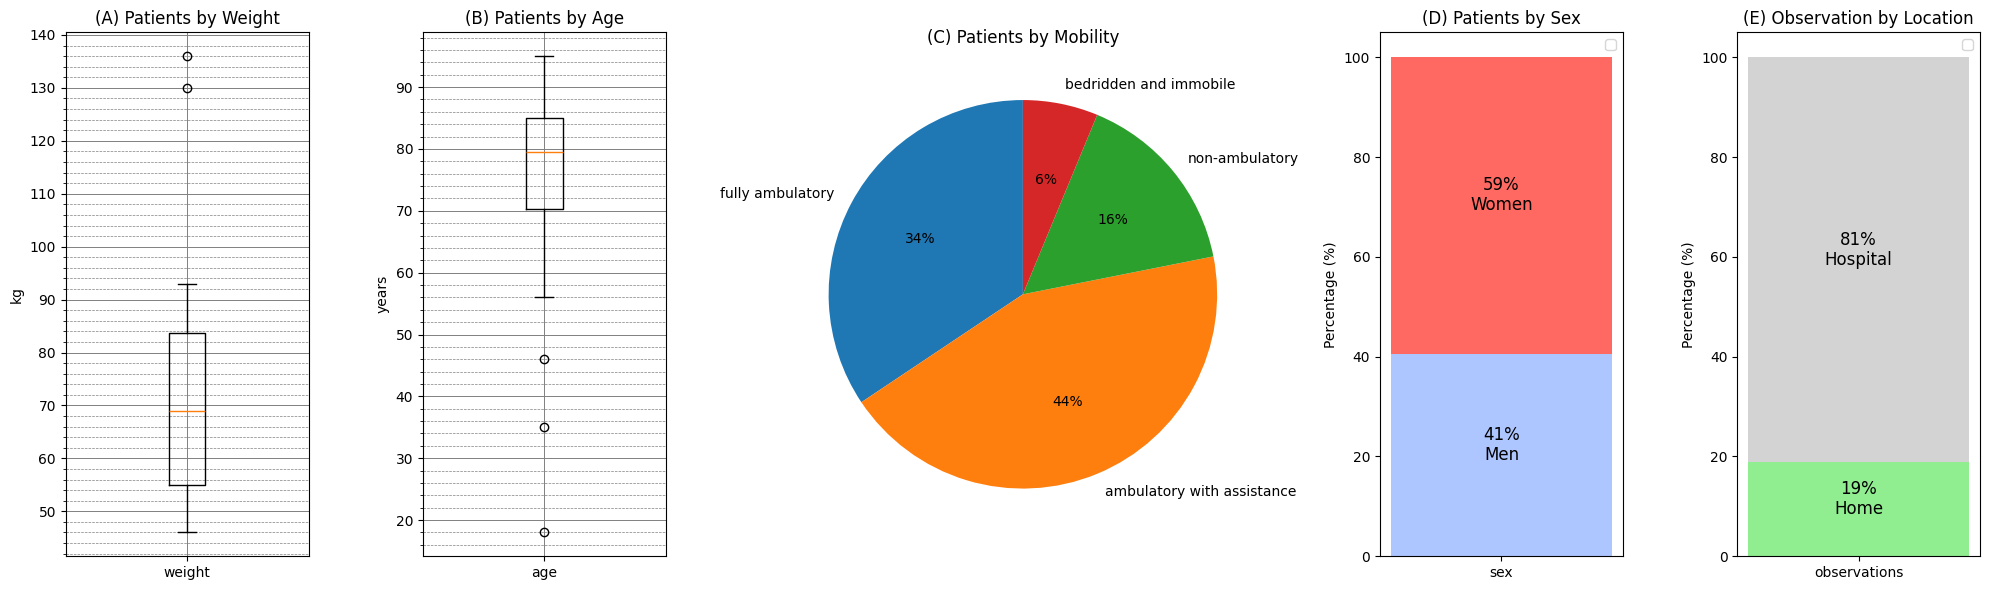

In [14]:
import matplotlib.pyplot as plt

# Data for boxplots
weights =weights = [130, 83, 49, 90, 47, 51, 76, 55, 88, 136, 84, 70, 81, 68, 46, 71, 47, 55, 93, 63, 77, 56, 60, 49, 85, 60]
ages = ages = [70, 79, 91, 73, 85, 79, 90, 95, 59, 81, 80, 85, 71, 85, 72, 71, 86, 95, 35, 83, 56, 65, 84, 93, 46, 18]

# Data for pie chart
patients_category = [11,14,5,2]
#category_labels = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
category_labels = ["fully ambulatory", "ambulatory with assistance", "non-ambulatory", "bedridden and immobile"]

# Data for stacked bar chart
men_counts = 13
women_counts = 19

# Calculate total and percentages
total_patients = men_counts + women_counts
men_percentage = (men_counts / total_patients) * 100
women_percentage = (women_counts / total_patients) * 100
total_categories = ['Total Patients']

# Define pastel colors
pastel_red = '#ff6961'
pastel_blue = '#AEC6FF'

# Create subplots with 1 row and 3 columns
#fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Create a 4x1 grid for the subplots (1 row, 4,gridspec_kw={'width_ratios': [2, 2, 1]} columns)
fig, axes = plt.subplots(1, 5, figsize=(20, 6),gridspec_kw={'width_ratios': [1, 1, 2, 1, 1]})

# 1. Boxplot for weights in the first column
axes[0].boxplot(weights, tick_labels=['weight'])
axes[0].set_title('(A) Patients by Weight')
axes[0].set_ylabel('kg')
# Set major ticks by 20 (default behavior)
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(10))

# Set minor ticks by 5
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(5))

# Enable minor ticks and grid
axes[0].minorticks_on()
# Set different grid styles for major and minor grids
axes[0].grid(True, which='major', linestyle='-', linewidth=0.7, color='gray')  # Solid line for major grid
axes[0].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray') # Dashed line for minor grid


# 2. Boxplot for ages in the second column
axes[1].boxplot(ages,tick_labels=['age'])
axes[1].set_title('(B) Patients by Age')
axes[1].set_xlabel('')
axes[1].set_ylabel('years')
# Set major ticks by 20 (default behavior)
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(10))

# Set minor ticks by 5
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(5))
# Enable minor ticks and grid
axes[1].minorticks_on()
# Set different grid styles for major and minor grids
axes[1].grid(True, which='major', linestyle='-', linewidth=0.7, color='gray')  # Solid line for major grid
axes[1].grid(True, which='minor', linestyle='--', linewidth=0.5, color='gray') # Dashed line for minor grid


# 3. Pie chart in the third column
axes[2].pie(patients_category, labels=category_labels, autopct='%1.0f%%', startangle=90)
axes[2].set_title('(C) Patients by Mobility')

# Example proportions for home and hospital observations
home_percentage = 10 / 53 * 100  
hospital_percentage = 43/ 53 * 100   

# 4. Stacked bar chart with men and women proportions in the fourth column
axes[3].bar(['sex'], men_percentage, color=pastel_blue)
axes[3].bar(['sex'], women_percentage, bottom=men_percentage, color=pastel_red)

# Second stacked bar for 'Observations'
axes[4].bar(['observations'], home_percentage, color='lightgreen')
axes[4].bar(['observations'], hospital_percentage, bottom=home_percentage, color='lightgrey')

# Add percentage labels for 'Patients' bar
axes[3].text(0, men_percentage / 2, 'Men', ha='center', va='center', color='black', fontsize=12)
axes[3].text(0, men_percentage + (women_percentage / 2), 'Women', ha='center', va='center', color='black', fontsize=12)

# Add percentage labels for 'Patients' bar
axes[3].text(0, men_percentage / 2+4, f'{men_percentage:.0f}%', ha='center', va='center', color='black', fontsize=12)
axes[3].text(0, men_percentage + (women_percentage / 2)+4, f'{women_percentage:.0f}%', ha='center', va='center', color='black', fontsize=12)

# Add percentage labels for 'Observations' bar
axes[4].text(0, home_percentage / 2, 'Home', ha='center', va='center', color='black', fontsize=12)
axes[4].text(0, home_percentage + (hospital_percentage / 2), 'Hospital', ha='center', va='center', color='black', fontsize=12)

# Add percentage labels for 'Observations' bar
axes[4].text(0, home_percentage / 2+4, f'{home_percentage:.0f}%', ha='center', va='center', color='black', fontsize=12)
axes[4].text(0, home_percentage + (hospital_percentage / 2)+4, f'{hospital_percentage:.0f}%', ha='center', va='center', color='black', fontsize=12)

axes[3].set_title('(D) Patients by Sex')
axes[3].set_ylabel('Percentage (%)')
axes[3].legend()

axes[4].set_title('(E) Observation by Location')
axes[4].set_ylabel('Percentage (%)')
axes[4].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot to a PNG file
plt.savefig("accuracy_study_patients_stored.png", format="png", dpi=300)
# Show the plots
plt.show()


## 7. Hospital vs Home performance metrics

In [15]:
observations_hospital = [obs for obs in observations if obs['device'].startswith('TINA-FTN')]
observations_home = [obs for obs in observations if not(obs['device'].startswith('TINA-FTN'))]

In [16]:
sen,spe,acc,ppv = accuracy_study(observations_hospital,'')

                          in bed     out bed    total     
sensor in bed             2153       333        2486      
sensor out bed            13         2003       2016      
total                     2166       2336                 
-----                                                     
sensitivity [%]           99.40                           
specificity [%]           85.74                           
pos. pred.v. [%]          86.60                           
neg. pred.v. [%]          99.36                           
prevalence [%]            32.44                           
accuracy [%]              92.31                           
pos. likelihood ratio LR+ 6.97                            
neg. likelihood ratio LR- 0.01                            
f1 score [%]              92.56                           
observations in study     43.00                           


In [17]:
sen2,spe2,acc2,ppv2 = accuracy_study(observations_home,'')

                          in bed     out bed    total     
sensor in bed             1489       53         1542      
sensor out bed            24         1217       1241      
total                     1513       1270                 
-----                                                     
sensitivity [%]           98.41                           
specificity [%]           95.83                           
pos. pred.v. [%]          96.56                           
neg. pred.v. [%]          98.07                           
prevalence [%]            52.90                           
accuracy [%]              97.23                           
pos. likelihood ratio LR+ 23.58                           
neg. likelihood ratio LR- 0.02                            
f1 score [%]              97.48                           
observations in study     10.00                           
